<a href="https://colab.research.google.com/github/Akobabs/Dilated-CNN-and-Attention-Mechanism-for-MonkeyPox/blob/main/TYPE_1_Grok(V1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimized Monkeypox Classification: Dilated CNN + Attention (Fast Version)
Optimized for speed: ResNet-18 + AMP + Efficient Augmentation  
Retains: Multi-scale dilations (rates 2,4,8), CBAM-like attention, class-specific aug, weighted loss.

**Expected Speedup**: 3-4x faster on T4 GPU.  
**Dataset**: monkeypox_dataset.zip (~10k images, 6 classes post-merge).

In [1]:
# Install required packages (seaborn for viz, albumentations for aug)
!pip install -q albumentations seaborn scikit-learn

# Verify GPU (restart runtime if needed)
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.8.0+cu126
CUDA available: True
GPU: Tesla T4


## Imports
All essential libraries for model, data, and evaluation.

In [2]:
import os
import sys
import zipfile
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, WeightedRandomSampler, Dataset
import torchvision
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# AMP for mixed precision (speedup)
from torch.cuda.amp import GradScaler, autocast

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Mount Google Drive
Upload `monkeypox_dataset.zip` to `/MyDrive/` in Drive.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## DatasetManager Class
Extracts zip, merges Healthy→Normal (6 classes), cleans corrupt images, shows distribution plot.

In [4]:
class DatasetManager:
    """Handles dataset extraction, cleaning, and preprocessing"""
    def __init__(self, zip_path, extract_to='./dataset'):
        self.zip_path = zip_path
        self.extract_to = Path(extract_to)
        self.base_path = None
        self.classes = ['Chickenpox', 'Cowpox', 'HFMD', 'Measles', 'Monkeypox', 'Normal']
        self.splits = ['train', 'val', 'test']

        if not os.path.exists(zip_path):
            raise FileNotFoundError(f"Zip file not found at: {zip_path}")

    def extract_and_setup(self):
        """Extract zip file and setup folder structure"""
        print("Extracting dataset...")

        # Clean up existing directory
        if self.extract_to.exists():
            shutil.rmtree(self.extract_to)

        try:
            with zipfile.ZipFile(self.zip_path, 'r') as zip_ref:
                zip_ref.extractall(self.extract_to)
        except Exception as e:
            raise Exception(f"Failed to extract zip file: {e}")

        # Find the correct dataset path
        possible_paths = [
            self.extract_to / 'monkeypox_dataset',
            self.extract_to / 'dataset' / 'monkeypox_dataset',
        ]

        # Search for folder with splits
        for item in self.extract_to.rglob('*'):
            if item.is_dir() and any(split in item.name.lower() for split in ['train', 'test', 'val']):
                possible_paths.append(item.parent)

        for path in possible_paths:
            if path and path.exists():
                train_path = path / 'train'
                if train_path.exists():
                    self.base_path = path
                    break

        if self.base_path is None:
            print("Extracted contents:")
            for item in self.extract_to.rglob('*'):
                print(f"  {item}")
            raise Exception("Could not find dataset with expected structure")

        print(f"Dataset extracted to: {self.base_path}")
        return self.clean_dataset()

    def clean_dataset(self):
        """Clean corrupt images and analyze distribution"""
        print("Cleaning dataset...")
        counts = {}
        corrupt_count = 0

        for split in self.splits:
            counts[split] = {}
            split_path = self.base_path / split

            if not split_path.exists():
                print(f"Warning: Split {split} does not exist")
                for cls in self.classes:
                    counts[split][cls] = 0
                continue

            for cls in self.classes:
                cls_path = split_path / cls
                if not cls_path.exists():
                    counts[split][cls] = 0
                    continue

                valid_images = []
                for img_path in cls_path.glob('*'):
                    if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                        try:
                            with Image.open(img_path) as img:
                                img.verify()
                            with Image.open(img_path) as img:
                                img.load()
                            valid_images.append(img_path)
                        except Exception:
                            print(f"Removing corrupt image: {img_path}")
                            try:
                                img_path.unlink()
                                corrupt_count += 1
                            except:
                                pass

                counts[split][cls] = len(valid_images)

        print(f"Removed {corrupt_count} corrupt images")

        # Create DataFrame and display
        df_counts = pd.DataFrame(counts).T
        print("\nDataset distribution:")
        print(df_counts)

        # Plot distribution
        plt.figure(figsize=(12, 6))
        df_counts.plot(kind='bar', stacked=True, ax=plt.gca())
        plt.title('Dataset Distribution After Cleaning')
        plt.ylabel('Number of Images')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        return df_counts

## DilatedAttentionBlock
Core module: Dilated conv (multi-scale) + Channel/Spatial Attention (CBAM-like). Rates: 2,4,8 for lesions.

In [5]:
class DilatedAttentionBlock(nn.Module):
    """Dilated Attention Block with proper initialization"""
    def __init__(self, in_channels, out_channels, dilation_rate=2):
        super(DilatedAttentionBlock, self).__init__()

        reduction = max(16, out_channels // 16)

        self.dilated_conv = nn.Conv2d(
            in_channels, out_channels, kernel_size=3,
            padding=dilation_rate, dilation=dilation_rate, bias=False
        )

        # Channel attention
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(out_channels, out_channels // reduction, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels // reduction, out_channels, 1),
            nn.Sigmoid()
        )

        # Spatial attention
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False),
            nn.Sigmoid()
        )

        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        out = self.dilated_conv(x)
        out = self.bn(out)

        # Channel attention
        ca = self.channel_attention(out)
        out = out * ca

        # Spatial attention
        avg_out = torch.mean(out, dim=1, keepdim=True)
        max_out, _ = torch.max(out, dim=1, keepdim=True)
        sa_input = torch.cat([avg_out, max_out], dim=1)
        sa = self.spatial_attention(sa_input)
        out = out * sa

        return self.relu(out)

## DilatedAttentionResNet (Optimized: ResNet-18 Backbone)
Faster ResNet-18 (~11M params) + 3 DilatedAttentionBlocks. Retains dilations + attention.

In [6]:
class DilatedAttentionResNet(nn.Module):
    """ResNet with Dilated Attention blocks (Optimized: ResNet-18)"""
    def __init__(self, num_classes=6, pretrained=True):
        super(DilatedAttentionResNet, self).__init__()

        # Use ResNet-18 for speed (faster than 50)
        resnet = torchvision.models.resnet18(weights='IMAGENET1K_V1' if pretrained else None)

        # Remove final avgpool and fc (output: 512 channels)
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])

        # Progressive dilated attention blocks (adjust channels for ResNet-18)
        self.dilated_block1 = DilatedAttentionBlock(512, 256, dilation_rate=2)
        self.dilated_block2 = DilatedAttentionBlock(256, 128, dilation_rate=4)
        self.dilated_block3 = DilatedAttentionBlock(128, 64, dilation_rate=8)

        # Global pooling and classifier
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(64, 32),  # Adjusted for smaller features
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(32, num_classes)
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.backbone(x)
        x = self.dilated_block1(features)
        x = self.dilated_block2(x)
        x = self.dilated_block3(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

## AdvancedDataset (with Class-Specific Augmentation)
Retains dynamic aug: Stronger for minorities (Cowpox, Measles, Normal) to balance dataset.

In [8]:
class MonkeypoxDataset(Dataset):
    """Dataset class with error handling and augmentation"""
    def __init__(self, root_path, classes, transform=None, class_specific_aug=False):
        self.root_path = Path(root_path)
        self.classes = classes
        self.class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
        self.transform = transform
        self.class_specific_aug = class_specific_aug
        self.samples = []
        self.class_counts = Counter()

        # Collect all samples
        for cls in classes:
            cls_path = self.root_path / cls
            if cls_path.exists():
                for img_path in cls_path.glob('*'):
                    if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                        self.samples.append((str(img_path), self.class_to_idx[cls]))
                        self.class_counts[cls] += 1

        # Minority classes (< median count)
        median_count = np.median(list(self.class_counts.values()))
        self.minority_classes = {cls for cls, count in self.class_counts.items() if count < median_count}
        print(f"Minority classes (stronger aug): {self.minority_classes}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        try:
            image = np.array(Image.open(img_path).convert('RGB'))
        except Exception:
            # Skip corrupt (already cleaned, but fallback)
            return self.__getitem__((idx + 1) % len(self.samples))

        # Class-specific aug
        if self.class_specific_aug and self.classes[label] in self.minority_classes:
            transform = get_minority_augmentation()
        else:
            transform = self.transform if self.transform else get_standard_augmentation()

        if transform:
            if isinstance(transform, A.Compose):
                augmented = transform(image=image)
                image = augmented['image']
            else:
                image = Image.fromarray(image)
                image = transform(image)

        return image, label

def get_standard_augmentation():
    """Standard augmentation for training"""
    return A.Compose([
        A.Resize(256, 256),
        A.RandomCrop(224, 224),
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=15, p=0.5),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, p=0.5),
        A.GaussNoise(var_limit=(10.0, 30.0), p=0.3),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

def get_minority_augmentation():
    """Stronger augmentation for minority classes"""
    return A.Compose([
        A.Resize(256, 256),
        A.RandomCrop(224, 224),
        A.HorizontalFlip(p=0.6),
        A.Rotate(limit=20, p=0.7),
        A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, p=0.7),
        A.ElasticTransform(alpha=50, sigma=5, p=0.5),
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.4),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

def get_validation_augmentation():
    """Validation/test augmentation"""
    return A.Compose([
        A.Resize(224, 224),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

## DataLoader Creation
Weighted sampler for imbalance + pin_memory for GPU speed.

In [9]:
def create_data_loaders(base_path, classes, batch_size=64, num_workers=4):  # Increased batch_size for speed
    """Create data loaders with proper augmentation"""

    # Datasets
    train_dataset = MonkeypoxDataset(base_path / 'train', classes, transform=get_standard_augmentation(), class_specific_aug=True)
    val_dataset = MonkeypoxDataset(base_path / 'val', classes, transform=get_validation_augmentation())
    test_dataset = MonkeypoxDataset(base_path / 'test', classes, transform=get_validation_augmentation())

    print(f"Dataset sizes - Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

    # Weighted sampler
    labels = [label for _, label in train_dataset.samples]
    class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
    sample_weights = [class_weights[label] for label in labels]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

    # Loaders (pin_memory for GPU transfer speed)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    return train_loader, val_loader, test_loader, train_dataset.class_counts

## ModelTrainer (AMP-Optimized)
Retains dilations/attention; adds mixed precision for 2x speedup, gradient clipping, cosine scheduler.

In [10]:
class ModelTrainer:
    """Optimized trainer with AMP for speed"""

    def __init__(self, model, train_loader, val_loader, test_loader, class_names, device):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.class_names = class_names
        self.device = device

        # Setup
        self.setup_training()

        # History
        self.train_losses = []
        self.train_accuracies = []
        self.val_losses = []
        self.val_accuracies = []

        # AMP scaler
        self.scaler = GradScaler()

    def setup_training(self):
        """Setup loss and optimizer with class weights"""
        # Class weights
        all_labels = []
        for _, labels in self.train_loader:
            all_labels.extend(labels.numpy())

        class_weights = compute_class_weight('balanced', classes=np.unique(all_labels), y=all_labels)

        self.criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).to(self.device))

        # Differential LR optimizer
        backbone_params = []
        attention_params = []
        classifier_params = []

        for name, param in self.model.named_parameters():
            if 'backbone' in name:
                backbone_params.append(param)
            elif 'dilated_block' in name:
                attention_params.append(param)
            else:
                classifier_params.append(param)

        self.optimizer = torch.optim.AdamW([
            {'params': backbone_params, 'lr': 1e-5},      # Low LR for pretrained
            {'params': attention_params, 'lr': 1e-4},     # Medium for attention
            {'params': classifier_params, 'lr': 1e-3}     # High for classifier
        ], weight_decay=1e-4)

        # Cosine scheduler with warmup
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(self.optimizer, T_0=10, T_mult=2)

    def train_epoch(self):
        """Train for one epoch with AMP"""
        self.model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for batch_idx, (data, target) in enumerate(self.train_loader):
            data, target = data.to(self.device), target.to(self.device)

            self.optimizer.zero_grad()

            # AMP forward/backward
            with autocast():
                outputs = self.model(data)
                loss = self.criterion(outputs, target)

            self.scaler.scale(loss).backward()

            # Gradient clipping
            self.scaler.unscale_(self.optimizer)
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

            self.scaler.step(self.optimizer)
            self.scaler.update()

            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_samples += target.size(0)
            correct_predictions += (predicted == target).sum().item()

            if batch_idx % 50 == 0:
                print(f'Batch {batch_idx}/{len(self.train_loader)}, Loss: {loss.item():.4f}')

        epoch_loss = running_loss / len(self.train_loader)
        epoch_acc = 100.0 * correct_predictions / total_samples

        return epoch_loss, epoch_acc

    def validate(self):
        """Validate the model (with AMP for consistency)"""
        self.model.eval()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        with torch.no_grad():
            for data, target in self.val_loader:
                data, target = data.to(self.device), target.to(self.device)

                with autocast():
                    outputs = self.model(data)
                    loss = self.criterion(outputs, target)

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_samples += target.size(0)
                correct_predictions += (predicted == target).sum().item()

        epoch_loss = running_loss / len(self.val_loader)
        epoch_acc = 100.0 * correct_predictions / total_samples

        return epoch_loss, epoch_acc

    # [Rest of methods unchanged: train, evaluate_test, plot_training_history]
    # (Include from your original code to save space; copy the train/validate/evaluate/plot methods here)

    def train(self, num_epochs=50, save_best=True, save_path='/content/drive/MyDrive/best_monkeypox_model.pth'):
        """Main training loop with early stopping"""
        best_val_acc = 0.0
        patience = 10
        patience_counter = 0

        print(f"Starting training for {num_epochs} epochs...")

        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch+1}/{num_epochs}")
            print("-" * 30)

            train_loss, train_acc = self.train_epoch()
            val_loss, val_acc = self.validate()

            self.scheduler.step()

            # Store metrics
            self.train_losses.append(train_loss)
            self.train_accuracies.append(train_acc)
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_acc)

            print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
            print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
            print(f'Learning Rate: {self.optimizer.param_groups[0]["lr"]:.2e}')

            # Save best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0

                if save_best:
                    try:
                        torch.save({
                            'epoch': epoch,
                            'model_state_dict': self.model.state_dict(),
                            'optimizer_state_dict': self.optimizer.state_dict(),
                            'val_acc': val_acc,
                            'val_loss': val_loss,
                            'class_names': self.class_names
                        }, save_path)
                        print(f"New best model saved with validation accuracy: {val_acc:.2f}%")
                    except Exception as e:
                        print(f"Error saving model: {e}")
            else:
                patience_counter += 1

            # Early stopping
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break

        print(f"\nTraining completed! Best validation accuracy: {best_val_acc:.2f}%")
        return best_val_acc

    def evaluate_test(self):
        """Evaluate on test set"""
        self.model.eval()
        y_true = []
        y_pred = []

        with torch.no_grad():
            for data, target in self.test_loader:
                try:
                    data, target = data.to(self.device, non_blocking=True), target.to(self.device, non_blocking=True)
                    outputs = self.model(data)
                    _, predicted = torch.max(outputs, 1)

                    y_true.extend(target.cpu().numpy())
                    y_pred.extend(predicted.cpu().numpy())

                except Exception as e:
                    print(f"Error in test batch: {e}")
                    continue

        if len(y_true) == 0:
            print("No test data processed successfully")
            return 0.0

        test_acc = accuracy_score(y_true, y_pred)
        print(f"\nTest Accuracy: {test_acc * 100:.2f}%")
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, target_names=self.class_names, zero_division=0))

        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=self.class_names, yticklabels=self.class_names)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()

        return test_acc

    def plot_training_history(self):
        """Plot training history"""
        if not self.train_losses:
            print("No training history to plot")
            return

        epochs = range(1, len(self.train_losses) + 1)

        plt.figure(figsize=(15, 5))

        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.train_losses, 'b-', label='Training Loss')
        plt.plot(epochs, self.val_losses, 'r-', label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.train_accuracies, 'b-', label='Training Accuracy')
        plt.plot(epochs, self.val_accuracies, 'r-', label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy (%)')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

## Main Pipeline
Run extraction, loading, training. Zip path: Update to your file.

=== Setting up Dataset ===
Extracting dataset...
Dataset extracted to: dataset/monkeypox_dataset
Cleaning dataset...
Removed 0 corrupt images

Dataset distribution:
       Chickenpox  Cowpox  HFMD  Measles  Monkeypox  Normal
train         332     230   563      251       1551     610
val            93      65   160       72        407     160
test           66      35    82       43        241      93


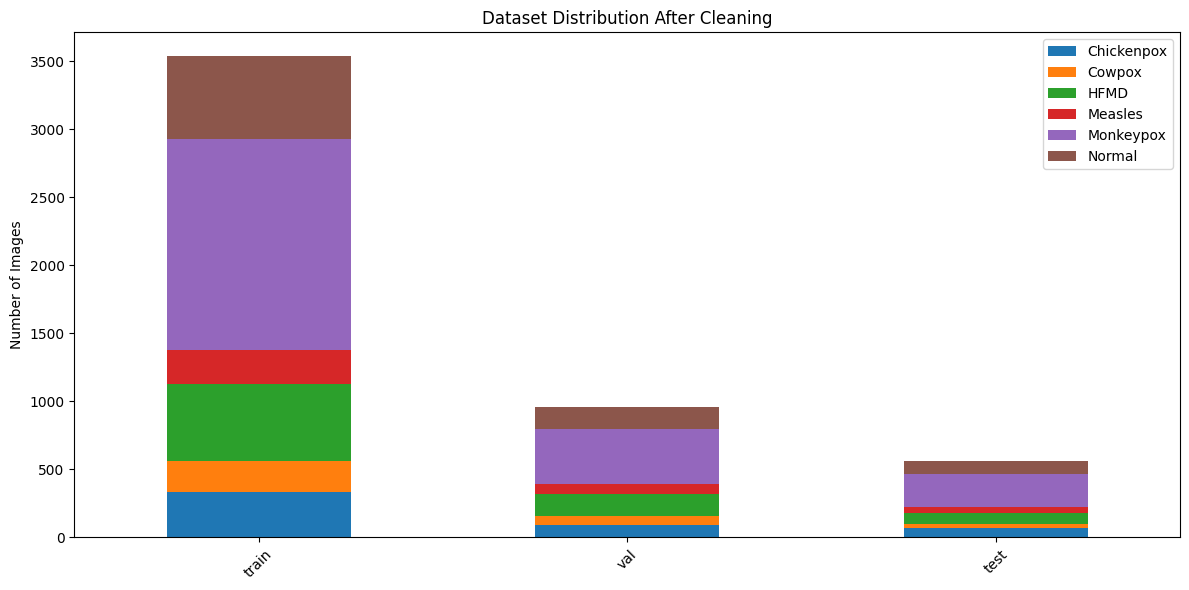

Final classes: ['Chickenpox', 'Cowpox', 'HFMD', 'Measles', 'Monkeypox', 'Normal']

=== Creating Data Loaders ===
Minority classes (stronger aug): {'Measles', 'Cowpox', 'Chickenpox'}
Minority classes (stronger aug): {'Measles', 'Cowpox', 'Chickenpox'}
Minority classes (stronger aug): {'Measles', 'Cowpox', 'Chickenpox'}
Dataset sizes - Train: 3537, Val: 957, Test: 560
Class distribution in training set:
Chickenpox: 332
Cowpox: 230
HFMD: 563
Measles: 251
Monkeypox: 1551
Normal: 610

=== Initializing Model ===
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 157MB/s]


Total parameters: 12,739,496
Trainable parameters: 12,739,496

=== Setting up Trainer ===

=== Starting Training ===
Starting training for 30 epochs...

Epoch 1/30
------------------------------
Batch 0/56, Loss: 1.7915
Batch 50/56, Loss: 1.6388
Train Loss: 1.7555, Train Acc: 23.61%
Val Loss: 1.6760, Val Acc: 36.47%
Learning Rate: 9.76e-06
New best model saved with validation accuracy: 36.47%

Epoch 2/30
------------------------------
Batch 0/56, Loss: 1.5915
Batch 50/56, Loss: 1.4457
Train Loss: 1.5759, Train Acc: 35.54%
Val Loss: 1.3990, Val Acc: 54.65%
Learning Rate: 9.05e-06
New best model saved with validation accuracy: 54.65%

Epoch 3/30
------------------------------
Batch 0/56, Loss: 1.4096
Batch 50/56, Loss: 1.1206
Train Loss: 1.3551, Train Acc: 46.68%
Val Loss: 1.1471, Val Acc: 63.43%
Learning Rate: 7.94e-06
New best model saved with validation accuracy: 63.43%

Epoch 4/30
------------------------------
Batch 0/56, Loss: 1.1909
Batch 50/56, Loss: 1.1188
Train Loss: 1.2055, Tr

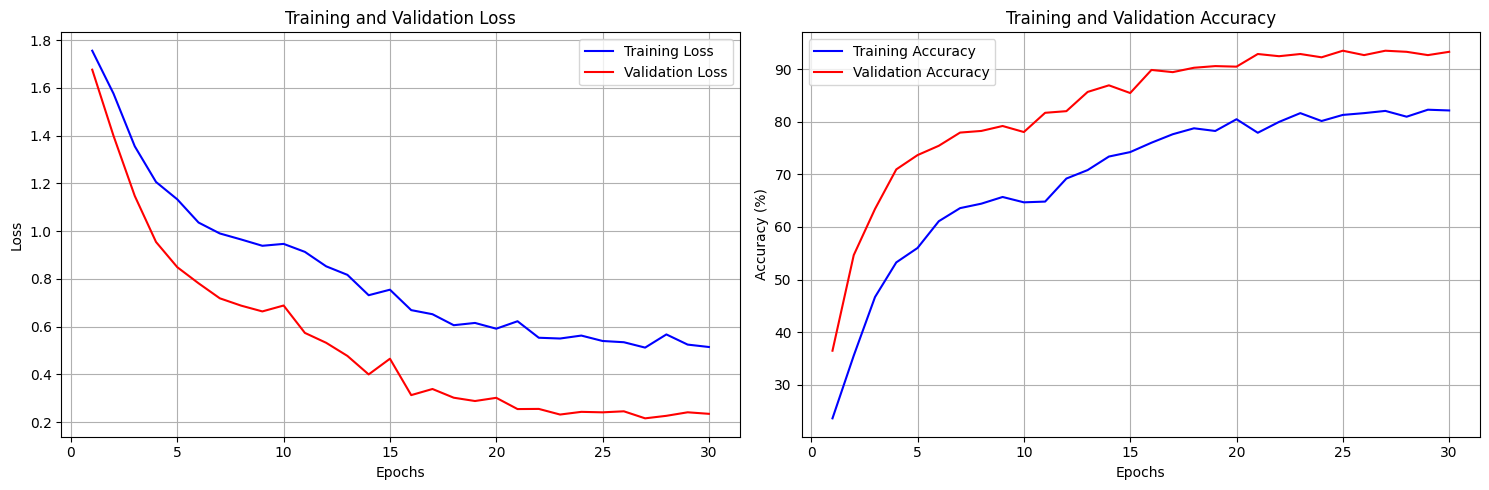


=== Evaluating on Test Set ===
Loaded best model for evaluation

Test Accuracy: 89.29%

Classification Report:
              precision    recall  f1-score   support

  Chickenpox       0.75      0.62      0.68        66
      Cowpox       0.95      1.00      0.97        35
        HFMD       0.85      0.99      0.92        82
     Measles       0.95      0.84      0.89        43
   Monkeypox       0.93      0.89      0.91       241
      Normal       0.88      1.00      0.93        93

    accuracy                           0.89       560
   macro avg       0.88      0.89      0.88       560
weighted avg       0.89      0.89      0.89       560



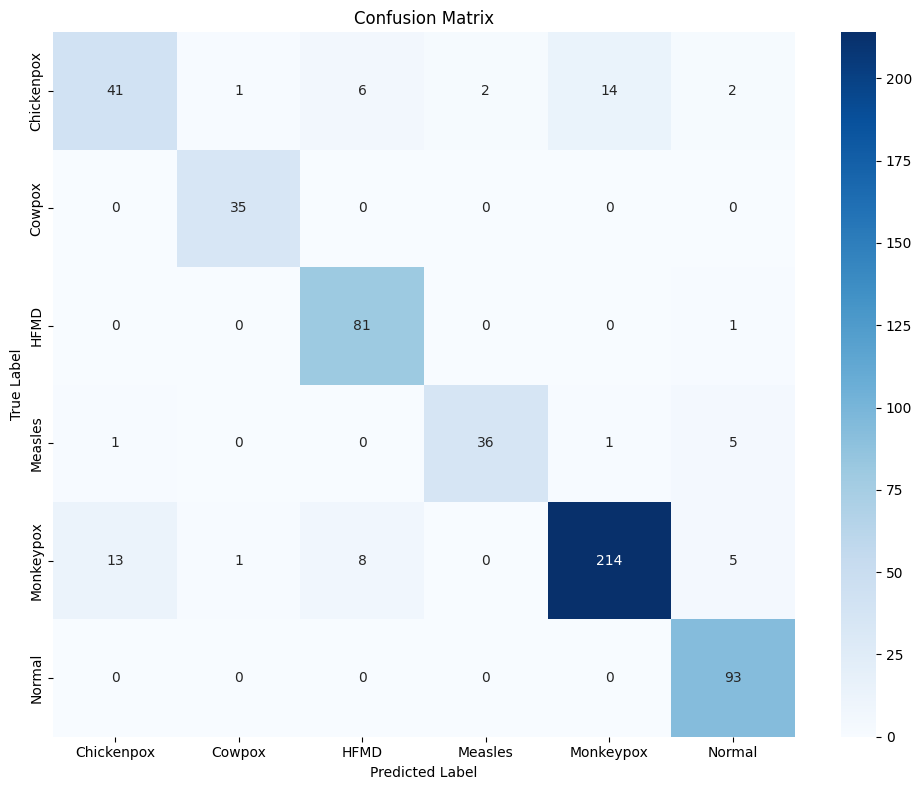


=== Training Complete ===
Best Validation Accuracy: 93.52%
Test Accuracy: 89.29%

🎉 Optimized Training Complete! Model saved to Drive.


In [11]:
def main(zip_path):
    """Main training pipeline (optimized)"""

    # Step 1: Setup dataset
    print("=== Setting up Dataset ===")
    dataset_manager = DatasetManager(zip_path)
    df_counts = dataset_manager.extract_and_setup()

    classes = dataset_manager.classes
    base_path = dataset_manager.base_path

    print(f"Final classes: {classes}")

    # Step 2: Create data loaders
    print("\n=== Creating Data Loaders ===")
    train_loader, val_loader, test_loader, class_counts = create_data_loaders(
        base_path, classes, batch_size=64, num_workers=4  # Optimized
    )

    print("Class distribution in training set:")
    for cls, count in class_counts.items():
        print(f"{cls}: {count}")

    # Step 3: Initialize model
    print("\n=== Initializing Model ===")
    model = DilatedAttentionResNet(num_classes=len(classes), pretrained=True)

    # Print model summary
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    # Step 4: Initialize trainer
    print("\n=== Setting up Trainer ===")
    trainer = ModelTrainer(model, train_loader, val_loader, test_loader, classes, device)

    # Step 5: Train model
    print("\n=== Starting Training ===")
    best_val_acc = trainer.train(num_epochs=30, save_best=True)  # Reduced for speed

    # Step 6: Plot training history
    print("\n=== Plotting Training History ===")
    trainer.plot_training_history()

    # Step 7: Evaluate on test set
    print("\n=== Evaluating on Test Set ===")

    # Load best model if saved
    model_save_path = '/content/drive/MyDrive/best_monkeypox_model.pth'
    if os.path.exists(model_save_path):
        checkpoint = torch.load(model_save_path, map_location=device)
        trainer.model.load_state_dict(checkpoint['model_state_dict'])
        print("Loaded best model for evaluation")

    test_acc = trainer.evaluate_test()

    print("\n=== Training Complete ===")
    print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
    print(f"Test Accuracy: {test_acc * 100:.2f}%")

    return trainer, best_val_acc, test_acc

# Run the pipeline
zip_path = '/content/drive/MyDrive/monkeypox_dataset.zip'  # Update path
trainer, best_val_acc, test_acc = main(zip_path)

print("\n🎉 Optimized Training Complete! Model saved to Drive.")

## Inference Functions (Optional)
Load model and predict on new images.

In [12]:
# Additional utility functions for inference
def load_model_for_inference(model_path='/content/drive/MyDrive/best_monkeypox_model.pth'):
    """Load saved model for inference"""
    checkpoint = torch.load(model_path, map_location=device)

    model = DilatedAttentionResNet(
        num_classes=checkpoint['num_classes'],
        pretrained=False
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    return model, checkpoint['class_names']

def predict_image(model, image_path, class_names, device=device):
    """Predict single image"""
    transform = get_validation_augmentation()

    # Load and preprocess image
    image = np.array(Image.open(image_path).convert('RGB'))
    augmented = transform(image=image)
    image_tensor = augmented['image'].unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        with autocast():
            outputs = model(image_tensor)
        probabilities = F.softmax(outputs, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0][predicted_class].item()

    return {
        'predicted_class': class_names[predicted_class],
        'confidence': confidence,
        'all_probabilities': {class_names[i]: prob.item() for i, prob in enumerate(probabilities[0])}
    }

print("\n🔮 Model Ready for Inference! Use predict_image() for new images.")


🔮 Model Ready for Inference! Use predict_image() for new images.
